In [5]:
import sqlite3
import pandas as pd

db = "chinook.db"

def run_query(query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)

def run_command(query):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        return conn.execute(query)

def show_tables():
    query = """ SELECT name, type FROM sqlite_master 
    WHERE type IN ("table", "view"); """
    
    return run_query(query)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

In [61]:
pop_albums = """ 

WITH genre_tracks as (SELECT g.name, COUNT(il.track_id) tracks_purchased FROM invoice_line il 

LEFT JOIN track t ON 

il.track_id = t.track_id LEFT JOIN genre g ON g.genre_id = t.genre_id LEFT JOIN invoice i ON

i.invoice_id = il.invoice_id LEFT JOIN customer c ON c.customer_id = i.customer_id 

WHERE c.country = "USA"

GROUP BY 1 ORDER BY 2 DESC)


SELECT *, CAST((tracks_purchased * 100) AS FLOAT) / CAST((SELECT SUM(tracks_purchased) FROM genre_tracks) AS FLOAT)

AS Percentage FROM genre_tracks

"""

p_albums = run_query(pop_albums)

p_albums.head(10)

,name,tracks_purchased,Percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Pop,22,2.093245
7,Latin,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


We know that Rock, Alternative & Punk and Metal are the most sold genres. Now let's find out the top most sold tracks from whom we will be able to purchase the track from, including:
1. the albums
2. genre
3. nr of times sold

In [37]:
choose_albums = """ 

SELECT t.name as track_name, g.name as genre, ar.name as artist_name, a.title as album_name,COUNT(i.invoice_id) as purchased_tracks FROM

track t LEFT JOIN invoice_line il ON il.track_id = t.track_id

LEFT JOIN invoice i ON i.invoice_id = il.invoice_id 

LEFT JOIN genre g ON g.genre_id = t.genre_id

LEFT JOIN album a ON a.album_id = t.album_id

LEFT JOIN artist ar ON ar.artist_id = a.artist_id

GROUP BY 1, 2, 3, 4 ORDER BY 5 DESC

; 

""" 

albums = run_query(choose_albums)

albums.head(20)

,track_name,genre,artist_name,album_name,purchased_tracks
0,War Pigs,Alternative,Cake,Cake: B-Sides and Rarities,31
1,Are You Experienced?,Rock,Jimi Hendrix,Are You Experienced?,14
2,Highway Chile,Rock,Jimi Hendrix,Are You Experienced?,14
3,Hey Joe,Rock,Jimi Hendrix,Are You Experienced?,13
4,Put The Finger On You,Rock,AC/DC,For Those About To Rock We Salute You,13
5,Third Stone From The Sun,Rock,Jimi Hendrix,Are You Experienced?,13
6,Love Or Confusion,Rock,Jimi Hendrix,Are You Experienced?,12
7,Radio/Video,Metal,System Of A Down,Mezmerize,12
8,51st Anniversary,Rock,Jimi Hendrix,Are You Experienced?,11
9,Dead And Broken,Metal,Godsmack,Faceless,11


In [42]:
top_albums = albums.groupby(["album_name", "artist_name", "genre"])["purchased_tracks"].sum().reset_index().sort_values(by="purchased_tracks", ascending=False).head(10)

top_albums

,album_name,artist_name,genre,purchased_tracks
27,Are You Experienced?,Jimi Hendrix,Rock,187
110,Faceless,Godsmack,Metal,96
197,Mezmerize,System Of A Down,Metal,93
120,Get Born,JET,Alternative & Punk,90
311,The Doors,The Doors,Rock,83
322,The Police Greatest Hits,The Police,Rock,80
129,Greatest Hits I,Queen,Rock,80
59,Big Ones,Aerosmith,Rock,80
117,From The Muddy Banks Of The Wishkah [live],Nirvana,Rock,78
212,My Generation - The Very Best Of The Who,The Who,Rock,76


We should buy the following Albums from the following artists:
1. Are you Experienced ? - By Jimi Hendrix
2. Faceless - By Godsmack
3. Mezmerize - from System of A Down
4. Get Born - JET

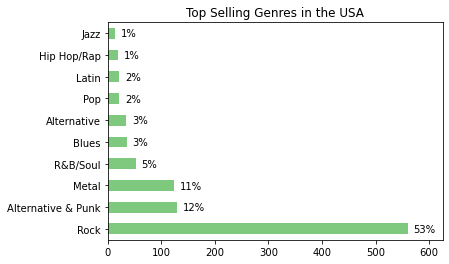

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

pop_albums = p_albums

pop_albums = pop_albums.head(10)

pop_albums.set_index("name", inplace=True, drop=True)

pop_albums["tracks_purchased"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent)

plt.ylabel('')

for i, label in enumerate(list(pop_albums.index)):
    score = pop_albums.loc[label, "tracks_purchased"]
    label = (pop_albums.loc[label, "Percentage"]).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))


plt.show()


## Analyzing Employee Sales Performance

1. Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.
2. Write a short statement describing your results, and providing a possible interpretation.

In [183]:

employee_performance = run_query( """

WITH employee_dollar AS

(SELECT e.employee_id, e.first_name || " " || e.last_name as employee_name, e.country,

e.title as employee_title, e.hire_date, e.birthdate,

SUM(i.total) as dollar_sales

FROM employee e LEFT JOIN customer c ON e.employee_id = c.support_rep_id

LEFT JOIN invoice i ON i.customer_id = c.customer_id


GROUP BY e.employee_id, employee_name, e.country, 
employee_title, e.hire_date, e.birthdate

ORDER BY dollar_sales DESC)

SELECT * FROM employee_dollar;


""" )

sales_agents = employee_performance[employee_performance["dollar_sales"].notnull()]


dollar_sales = np.array(sales_agents["dollar_sales"])


#Getting differences in dollars
a = dollar_sales[:, None] - dollar_sales
r = np.arange(dollar_sales.size)

dollar_delta = list(a[r[:, None] < r])

#Getting the differences in hire dates
sales_agents["hire_date"] = pd.to_datetime(sales_agents["hire_date"])

res = (pd.merge(sales_agents[["hire_date"]].reset_index(), sales_agents[["hire_date"]].reset_index(), how='cross').
      query("index_x > index_y").drop(columns=["index_x", "index_y"]))

res['diff'] = (res['hire_date_x'] - res['hire_date_y']).dt.days

days_delta = res["diff"].to_list()

prep_df = [(dollar, day) for dollar, day in zip(dollar_delta, days_delta)]



result = pd.DataFrame(prep_df, columns=["Dollar-Sales", "Days Difference"])


/var/folders/kk/v47zgwqd72z5_5_wynlh914m0000gn/T/ipykernel_19472/1413280674.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_agents["hire_date"] = pd.to_datetime(sales_agents["hire_date"])


In [184]:
emp = (pd.merge(sales_agents[["employee_name"]].reset_index(), sales_agents[["employee_name"]].reset_index(), how="cross").
query("index_x > index_y")).drop(columns=["index_x", "index_y"])
emp["emp_result"] = emp["employee_name_x"] + " > " + emp["employee_name_y"]
emp.reset_index(inplace=True)

result = result.join(emp["emp_result"])

result = result[["emp_result", "Dollar-Sales", "Days Difference"]]

result

,emp_result,Dollar-Sales,Days Difference
0,Margaret Park > Jane Peacock,147.51,32
1,Steve Johnson > Jane Peacock,337.59,199
2,Steve Johnson > Margaret Park,190.08,167


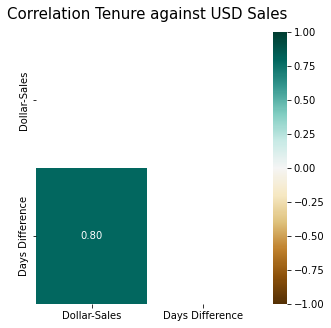

In [196]:
import seaborn as sns

plt.figure(figsize=(5, 5))
mask = np.triu(np.ones_like(result.corr(), dtype=bool))
heatmap = sns.heatmap(result.corr(), mask=mask, vmax=1, vmin=-1, annot=True, cmap="BrBG", fmt=".2f")
heatmap.set_title("Correlation Tenure against USD Sales", fontdict={"fontsize":15}, pad=13)
plt.show()

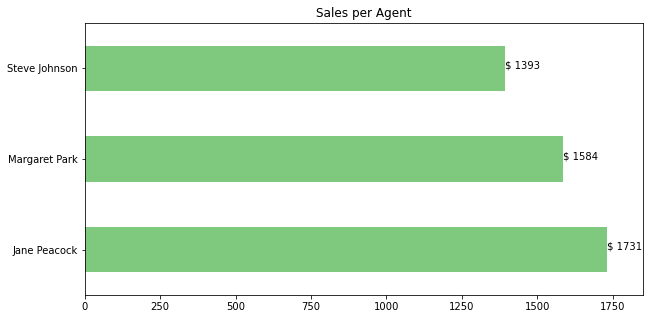

In [224]:

s_plot = sales_agents.copy()

plt.figure(figsize=(10,5))

s_plot.set_index("employee_name", inplace=True, drop=True)

s_plot["dollar_sales"].plot.barh(title="Sales per Agent",
                                 xlim=(0, 1850),
                                 colormap=plt.cm.Accent)

plt.ylabel("")

for n, emp in enumerate(s_plot.index):
    label = s_plot.loc[emp, "dollar_sales"]
    str_label = "$ " + label.astype(int).astype(str)
    plt.annotate(str_label, (label, n))

plt.show()

## Analyzing Sales by Country

For each country, we must find out the following:
    1. Total number of customers
    2. Total value of sales
    3. Average value of sales per customer
    4. Average order value ($ Sales / # of invoices)

Countries with only one customer should be grouped as "Other" and put at the end.

In [312]:
country_q = """

WITH nr_customers AS ( SELECT c.country, (SELECT COUNT(*) FROM customer WHERE country = c.country) as 
    nr_customers,

    SUM(i.total) as total_sales,
    COUNT(i.customer_id) as purchase_volume
 
    FROM customer c 
    LEFT JOIN invoice i ON i.customer_id = c.customer_id 

    GROUP BY country ORDER BY nr_customers DESC),
    
before_grouping AS (SELECT country, nr_customers as distinct_customers, total_sales,
    total_sales / purchase_volume as average_sales,
    total_sales / nr_customers as customer_lifetime_value, 
    
    CASE WHEN nr_customers.nr_customers = 1 THEN "Other"
    ELSE country
    END AS customer_origin
    FROM nr_customers),
    
after_grouping AS (SELECT customer_origin, SUM(distinct_customers) as total_customers,
    SUM(total_sales) as total_sales,
    AVG(average_sales) as average_sales,
    AVG(customer_lifetime_value) as customer_lifetime_value
    FROM 
    
    (SELECT before_grouping.*,
    CASE WHEN customer_origin = "Other" THEN 0
    ELSE 1
    END AS sort FROM before_grouping)

    GROUP BY customer_origin
    ORDER BY sort DESC, total_customers DESC, total_sales DESC, customer_lifetime_value DESC)
    
    
SELECT * FROM after_grouping

"""

customer_analytics = run_query(country_q)

customer_analytics

,customer_origin,total_customers,total_sales,average_sales,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,United Kingdom,3,245.52,8.768571,81.840000
6,Czech Republic,2,273.24,9.108000,136.620000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.445071,72.996000


We can conclude that:

    1. USA, Canada and Brazil incur the highest total sales. 
    2. Average sales (total value per invoice) is highest to USA, with almost 8$
    3. Customer lifetime value is highest in Czech Republic, Portugal and India which means that few customers purchase high amounts
    
## Data Visualization in Countries:

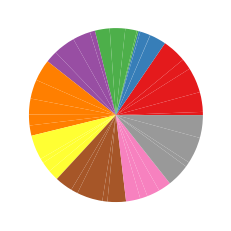

In [354]:
import random

def hex_color():
    r = lambda: random.randint(0, 255)
    hex_color = '#%02X%02X%02X' % (r(),r(),r())
    return hex_color

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
a=np.random.random(40)
cs=cm.Set1(np.arange(40)/40.)
f=plt.figure()
ax=f.add_subplot(111, aspect='equal')
p=plt.pie(a, colors=cs)
plt.show()
    

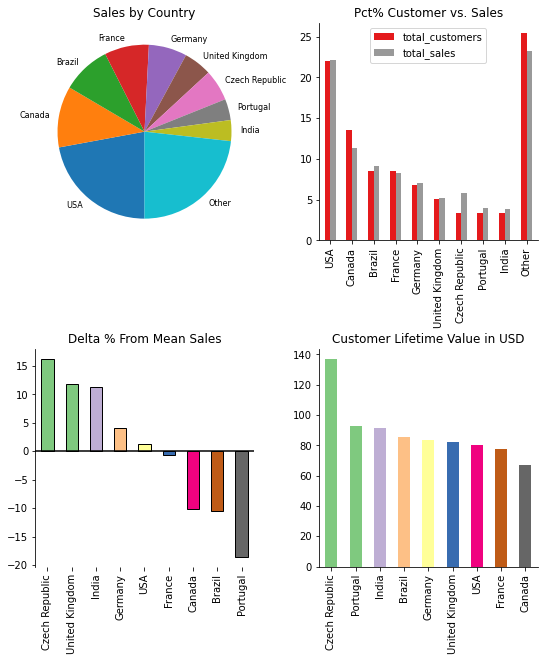

In [453]:
from matplotlib import cm

c_analytics = customer_analytics.copy()

c_analytics.set_index("customer_origin", drop=True, inplace=True)

rows = len(c_analytics)

cs = cm.Set1(np.arange(rows) / rows)


#Plt.cm.Accent generates a series of 4 color-codes

colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, c_analytics.shape[0])]

#Fig represents the figure, axes are the individual subplots

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))

#Like that we can reference each of them individually

ax1, ax2, ax3, ax4 = axes.flatten()

#Adjust the height between subplots

fig.subplots_adjust(hspace=0.5, wspace=0.3)

#Top left

sales_countries = c_analytics["total_sales"].copy().rename("")

sales_countries.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title="Sales by Country",
    colormap=plt.cm.tab10,
    fontsize=8,
    wedgeprops={"linewidth":0})

#

top_right_cols = ["total_customers", "total_sales"]
cd_df = c_analytics[top_right_cols].copy()

cd_df.index.name = ""

for c in top_right_cols:
    cd_df[c] /= cd_df[c].sum() / 100

cd_df.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct% Customer vs. Sales"
)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


#Bottom left

avg_sales = c_analytics["average_sales"].sort_values(ascending=False).copy()
avg_sales.index.name = ""

delta_mean = ((avg_sales - avg_sales.mean()) / avg_sales.mean()) * 100
delta_mean = delta_mean.drop("Other")

delta_mean.plot.bar(
    ax=ax3,
    color=colors,
    title="Delta % From Mean Sales",
edgecolor="black")

ax3_remove = ["top", "right", "bottom"]

for spine in ax3_remove:
    ax3.spines[spine].set_visible(False)

ax3.axhline(0, color="black")

# bottom right
cust_value = c_analytics["customer_lifetime_value"].sort_values(ascending=False).copy()
cust_value.index.name = ""
cust_value.drop("Other", inplace=True)
cust_value.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value in USD")

ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()


## Purchasing Entire Albums Or Individual Tracks?

In [496]:
album_query = """

WITH tracks_purchased AS (
    SELECT il.invoice_id, t.album_id, COUNT(il.track_id) as purchased_tracks FROM invoice_line il LEFT JOIN
    track t ON il.track_id = t.track_id GROUP BY 1, 2),
    
    
    
    album_tracks AS (
    SELECT album_id as album_id2, COUNT(track_id) as all_tracks_from_album FROM track GROUP BY 1 ),
    
    
    
    purchased_vs_all AS (
    SELECT *, CASE
    
    WHEN purchased_tracks = all_tracks_from_album THEN 0
    ELSE 1 END AS "all_album"
    
    FROM (SELECT * FROM tracks_purchased tp LEFT JOIN album_tracks at ON tp.album_id = at.album_id2) ),

    
    album_bool AS (SELECT invoice_id, CASE
    WHEN all_album = 0 THEN "True"
    ELSE "False"
    END AS "all_album_final"
    FROM (
    SELECT invoice_id, SUM(all_album) as all_album FROM purchased_vs_all GROUP BY 1 )),
    
    
    final_table AS (SELECT all_album_final, COUNT(invoice_id) as invoice_count 
    FROM album_bool GROUP BY all_album_final)
    
    
    
    SELECT *, CAST(invoice_count AS FLOAT)
    /(SELECT SUM(invoice_count)
    FROM final_table) * 100 as
    percentage
    FROM final_table;


"""
run_query(album_query)

,all_album_final,invoice_count,percentage
0,False,500,81.433225
1,True,114,18.566775


To conclude, the recommendation is to sell by tracks and not by albums since most of the sales occur in individual songs.